In [1]:
import numpy as np 
import toblerone as tob
import pyvista as pv 
pv.set_plot_theme('document')
from surfplot import *
from scipy.spatial import ConvexHull
from tob_projectors import *
import matplotlib.pyplot as plt
from projection_test import loadfunc, loadnii

In [2]:
ins = tob.Surface('data/103818.L.white.32k_fs_LR.surf.gii')
mids = tob.Surface('data/103818.L.midthickness.32k_fs_LR.surf.gii')
outs = tob.Surface('data/103818.L.pial.32k_fs_LR.surf.gii')

In [3]:
fltr = np.isin(ins.tris, ins.tris[0,:]).any(1)
tris = ins.tris[fltr]

In [4]:
hull_ps = np.vstack((ins.points[tris[0,:],:], outs.points[tris[0,:],:]))
hull = ConvexHull(hull_ps)
n = 5
sx = np.linspace(0,1,2*n+1)[1:-1:2] - 0.5
sx,sy,sz = np.meshgrid(sx,sx,sx)
samps = np.vstack((sx.flatten(), sy.flatten(), sz.flatten())).T
samps = hull_ps.mean(0) + 3 * samps 
voxpoly = pv.PolyData(samps)

In [5]:
# def plotsurf(points, tris):
inps,ts = ins.rebaseTriangles(np.flatnonzero(fltr))
outps,ts = outs.rebaseTriangles(np.flatnonzero(fltr))

In [6]:
poly_tris = 3 * np.ones((ts.shape[0], ts.shape[1]+1), dtype=np.int32) 
poly_tris[:,1:] = ts 
inpoly = pv.PolyData(inps, poly_tris)
outpoly = pv.PolyData(outps, poly_tris)
flat_col = np.ones(inps.shape[0])
hulltris = 3 * np.ones((hull.simplices.shape[0], hull.simplices.shape[1]+1), dtype=np.int32) 
hulltris[:,1:] = hull.simplices
hullpoly = pv.PolyData(hull.points, hulltris)

In [7]:
p = pv.BackgroundPlotter()
p.add_mesh(inpoly, opacity=0.2, show_edges=True)
p.add_mesh(outpoly, opacity=0.2, show_edges=True)
p.add_mesh(hullpoly, scalars=np.ones(hull.points.shape[0]), opacity=0.4)
p.add_mesh(voxpoly, render_points_as_spheres=True, color='lightblue')
p.show()

In [8]:
# Simulate an activation 
def make_activation(for_surf, at_idx):
    metric = np.zeros(for_surf.points.shape[0])
    n1 = for_surf.tris[(for_surf.tris == at_idx).any(1),:].flatten()
    n2 = for_surf.tris[np.isin(for_surf.tris, n1).any(1),:].flatten()
    metric[n1] = 0.6
    metric[n2] = 0.8
    metric[at_idx] = 1 
    return metric 

plotsurf = tob.Surface(op.join('data/103818.L.very_inflated.32k_fs_LR.surf.gii'))
metric = make_activation(plotsurf, 9000)
poly = plotsurf.to_polydata()
p = pv.BackgroundPlotter()
p.add_mesh(poly, scalars=metric, cmap='cwr')
p.show()

In [9]:
tmetric = loadfunc('data/tob_activation.func.gii')
p = pv.BackgroundPlotter()
p.add_mesh(poly, scalars=tmetric, cmap='cwr')
p.show()

In [10]:
wmetric = loadfunc('data/wb_activation.func.gii')
p = pv.BackgroundPlotter()
p.add_mesh(poly, scalars=wmetric, cmap='cwr')
p.show()

In [6]:
hemi = tob.classes.Hemisphere('data/sph/in.surf.gii', 'data/sph/out.surf.gii', 'L')
spc = tob.ImageSpace('data/sph/ref.nii.gz')
hemi.apply_transform(spc.world2vox)
pvs = nib.load('data/sph/sph_fractions.nii.gz').get_fdata().reshape(-1,3)
hemi.PVs = pvs 

In [7]:
v2n = voxel2nodes_weights(spc, hemi, None, 10, True)
n2v = node2voxel_weights(spc, hemi, None, 10)
v2n.shape

(1642, 1000)

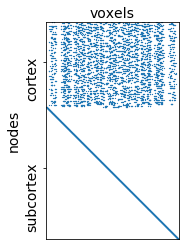

In [8]:
plt.rcParams.update({'font.size': 14})
ax = plt.gcf().gca()
ax.spy(v2n, markersize=0.3)
ax.set_xticks([])
ax.set_yticks([300, 1100])
ax.set_yticklabels(['cortex', 'subcortex'], rotation=90)
ax.xaxis.set_label_position('top')
ax.set_ylabel('nodes')
ax.set_xlabel('voxels')
plt.savefig('figs/v2n.png', dpi=500)
plt.show()

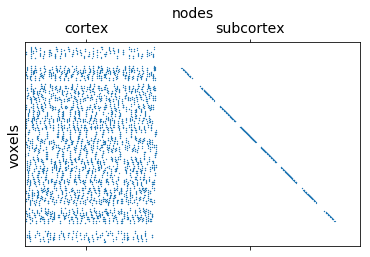

In [9]:
ax = plt.gcf().gca()
ax.spy(n2v, markersize=0.3)
ax.set_yticks([])
ax.xaxis.set_label_position('top')
ax.set_xlabel('nodes')
ax.set_ylabel('voxels')
ax.set_xticks([300, 1100])
ax.set_xticklabels(['cortex', 'subcortex'])
plt.savefig('figs/n2v.png', dpi=500)
plt.show()